# Love for sandwiches
## Visualization of the data gathered through [Lovac na sendiče](https://chrome.google.com/webstore/detail/lovac-na-sendvi%C4%8De/cebplboeldmlomimakpfhbhojajdpaki)

In this notebook I will explore the data I've gathered.<br>
My main focus is extracting the valid reactions to comments sent in by the user.<br>
<br>
The goal of this code is to figure out the couple of users that yield consistent reactions but still maintain a large percentage of the overall results. As we can see from the data, the large majority of the users only create a couple of reactions, and can be discarded as their answers cannot be easily validated.

In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import graphviz
from networkx import draw_spring as draw

from pymongo import MongoClient
client = MongoClient()

blic = client.blic
b92 = client.b92
n1 = client.n1

In [33]:
mpl.rcParams.update({'axes.titlesize': '20'})
mpl.rcParams.update({'axes.labelsize': '15'})
RED = '\033[91m'
BOLD = '\033[1m'
END = '\033[0m'

In [23]:
blic_comments = list(blic.comments.find())
b92_comments = list(b92.comments.find())
n1_comments = list(n1.comments.find())

blic_reactions = list(blic.reactions.find())
b92_reactions = list(b92.reactions.find())
n1_reactions = list(n1.reactions.find())

all_comments = blic_comments + b92_comments + n1_comments
all_reactions = blic_reactions + b92_reactions + n1_reactions

# Comment dictionary with comment_id's as indices
comments_dict = {}
for comment in all_comments:
    # FIXME: For some reason multiple same comments pop up. 
    comment['reactions'] = []
    comments_dict[comment['comment_id']] = comment
    
# Add the reactions to each comment
for reaction in all_reactions:
    if reaction['comment_id'] not in comments_dict:
#         print("Missing comment with ID: %s" % reaction['comment_id'])
        pass
    else:
        comments_dict[reaction['comment_id']]['reactions'].append(reaction)    

## Broj komentara:

In [24]:
print("Blic: %s" % blic.comments.count())
print("B92: %s" % b92.comments.count())
print("N1: %s" % n1.comments.count())
print("Ukupno: %s" % len(all_comments))

Blic: 3629
B92: 2231
N1: 511
Ukupno: 6371


## Broj korisnika:

In [25]:
print("Blic: %s " % len(blic.reactions.distinct('userid')))
print("B92: %s " % len(b92.reactions.distinct('userid')))
print("N1: %s " % len(n1.reactions.distinct('userid')))

user_ids = set()
for reaction in all_reactions:
    user_ids.add(reaction['userid'])
    
print("Ukupan broj korisnika na sva 3 sajta: %s" % len(user_ids))

Blic: 482 
B92: 140 
N1: 49 
Ukupan broj korisnika na sva 3 sajta: 572


## Broj reakcija po komentaru

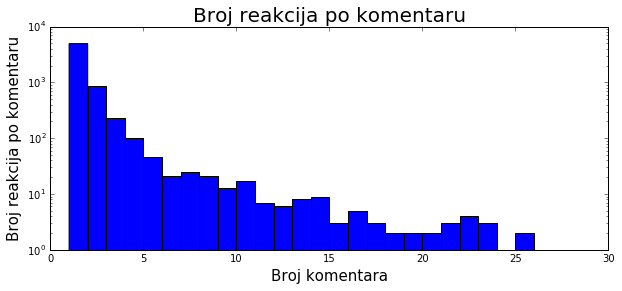

In [34]:
x = [len(x['reactions']) for x in all_comments]

plt.figure(figsize=(10,4))
n, bins, patches = plt.hist(x, range(1,30))

plt.xlabel('Broj komentara')
plt.ylabel('Broj reakcija po komentaru')
plt.yscale('log')
plt.title('Broj reakcija po komentaru')
plt.show()

## Histogram dužina komentara

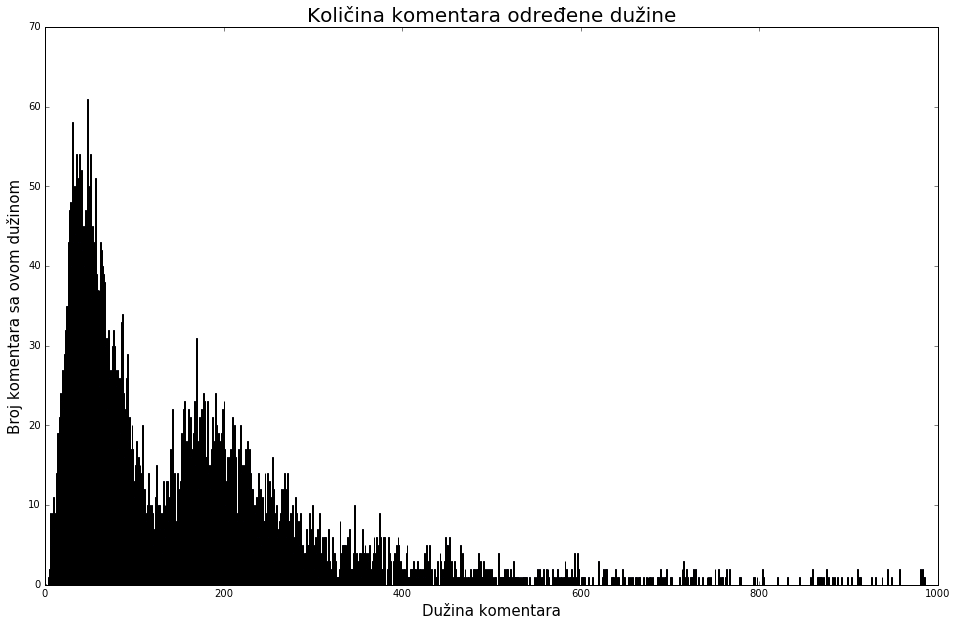

Najduži komentar (2528 karaktera): 
Istinu koju niko neće da objavi niti da preduzme mere kako bi sve stranke potpisale dokument koji bi bio obavezan da se usvoji odnosno donese zakon nakon izbora, bez obzira ko formirao vlast.Tim zakonom bi nakon smanjenja broja zaposlenih u javnim preduzećima išla komisija sastavljena od ... Proširi svevlasti ,opozicije i nestranačkih ljudi.Ta komisija bi proveravala  da li su izmišljena partijska mesta  zadržania,da li su potrebni radnici dobili otkaz......Ukoliko bi se utvrdilo da je tako, u roku od 3 meseca ispraviti nedostatak.Ukoliko se nepreduzme nešto po ovom pitanju Srbija ide u pravcu još jačeg partijskog zapošljavanja.Članska karta ima veći značaj od radne knjižice odnosno od sposobnosti,znanja i poštenja radnika.Većina ljudi koji su nepošteni učlanjeni su u neku stranku kako bi imali prednost, odnosno primali platu iz budžeta za svoj nerad.Ova trenutna opozicija se neprotivi jer i oni su deo sistema,Oko 2/3 vrha u svim  stranakama prima pl

In [35]:
lens = []
for comment in all_comments:
    if comment['comment'] is None:
        comment['comment'] = ""
    lens.append(len(comment['comment']))
       
plt.figure(figsize=(16,10))
n, bins, patches = plt.hist(lens, range(1, 1000))
plt.xlabel(u'Dužina komentara')
plt.ylabel(u'Broj komentara sa ovom dužinom')
plt.title(u'Količina komentara određene dužine')
plt.show()

idx_max = np.argmax(lens)
print("Najduži komentar (%s karaktera): " % len(all_comments[idx_max]['comment']))
print(all_comments[idx_max]['comment'])


## Komentari sa najviše reakcija:

In [8]:
popularity = []
for comment in all_comments:
    popularity.append(len(comment['reactions']))
    
sort_idx = np.argsort(popularity)
for i in range(1,6):
    comment = all_comments[sort_idx[-i]]
    bots = 0; nots = 0
    for reaction in comment['reactions']:
        if reaction['bot'] == 'true':
            bots += 1
        else:
            nots += 1

    print '\x1b[1;31m'+"Bot: %s, not: %s" % (bots, nots)+'\x1b[0m'
#     print "Bot: %s, not: %s" % (bots, nots)
    print comment['comment']
    print ""

Bot: 27, not: 0
Brze, pametne odluke nase Vlade su za pohvalu.

Bot: 26, not: 0
upravo to,ljudski zivot nema cenu, svaka cast nasoj vladi!!!

Bot: 25, not: 0
test

Bot: 1, not: 24
Gde ti vidis brzinu i razum kad je pola Srbije polavljeno ?
Sta uradise sa parama koje su dobili 2012 godine ?

Bot: 24, not: 0
Samo uz paljivo slusanje mera predostroznosti mozemo pobediti ovu bitku.



In [9]:
# comment_rnum = [len(comment['reactions']) for comment in all_comments]
# comment_rnum = np.array(comment_rnum)
# idx_best_10 = np.argsort(comment_rnum)[10:]
# for idx in idx_best_10:
#     print 'Komentar %s' % idx
#     print(all_comments[idx]['comment'])
#     for reaction in all_comments[idx]['reactions']:
#         print reaction['bot']

# Broj reakcija po korisniku

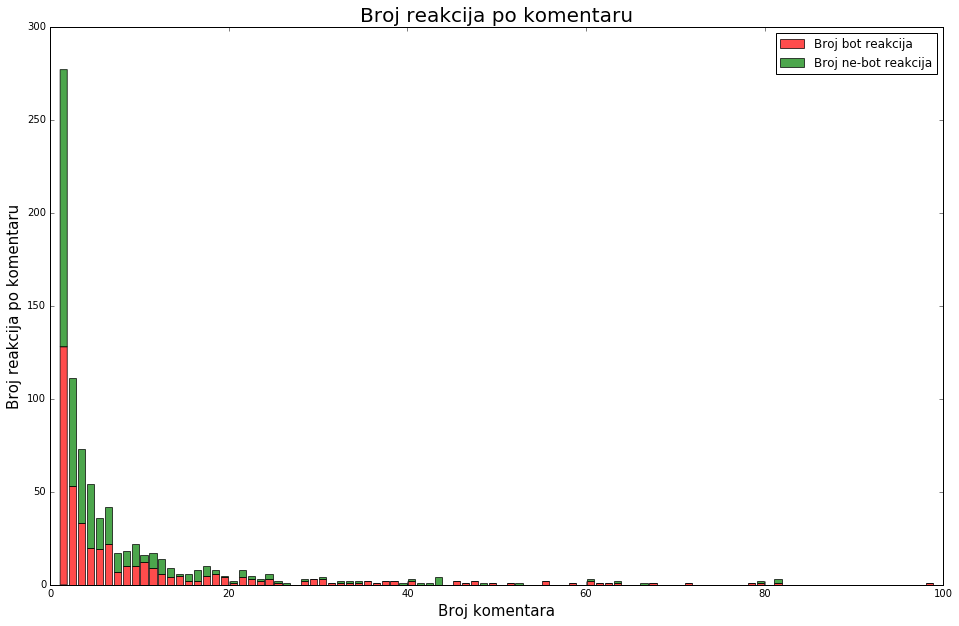

In [46]:
users_dict = {user: {'bot':0, 'not':0} for user in user_ids}

for reaction in all_reactions: 
    user_id = reaction['userid']
    
    if reaction['bot'] == u'false':
        users_dict[user_id]['not'] += 1
    elif reaction['bot'] == u'true':
        users_dict[user_id]['bot'] += 1

bots = list(user['bot'] for user in users_dict.values())
nots = list(user['not'] for user in users_dict.values())

plt.figure(figsize=(16,10))

n, bins, patches = plt.hist([bots, nots], range(1,100), color=['red', 'green'], alpha=0.7, stacked=True)

plt.xlabel('Broj komentara')
plt.ylabel('Broj reakcija po komentaru')
plt.title('Broj reakcija po komentaru')
plt.legend(["Broj bot reakcija", "Broj ne-bot reakcija"])
plt.show()

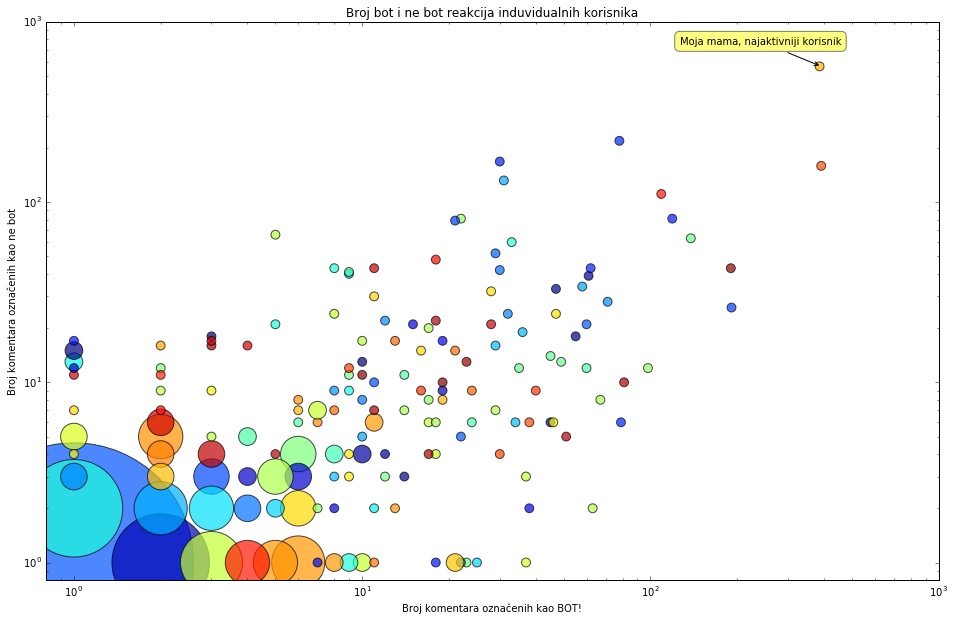

In [11]:
bots = [user['bot'] for user in users_dict.values()]
nots = [user['not'] for user in users_dict.values()]
botnot = [(bots[i], nots[i]) for i in range(len(bots))]
x = []
y = []
area = []

while len(botnot) > 0:
    bn = botnot[0]
    x.append(bn[0]), y.append(bn[1])
    area.append(botnot.count(bn))
    for i in range(botnot.count(bn)):
        botnot.remove(bn)

colors = np.random.rand(len(x))
area = np.array(area)
min_width = np.pi * 5 ** 2
area = (area ** 2) * min_width

plt.figure(figsize=(16,10))
fig = plt.scatter(x, y, s=area, c=colors, alpha=0.7)

# labels
plt.title(u"Broj bot i ne bot reakcija induvidualnih korisnika")
plt.xlabel(u"Broj komentara označenih kao BOT!")
plt.ylabel(u"Broj komentara označenih kao ne bot")

# # log scale
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8, 1000)
plt.xlim(0.8, 1000)

# # Majka
xm = max(bots)
ym = max(nots)
plt.annotate(
    "Moja mama, najaktivniji korisnik", 
    xy = (xm, ym), xytext = (20, 20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

# Graf korisnika sa slajderom.
### Node-ovi su korisnici. Korisnici koji su komentarisali na X istih komentara su povezani.

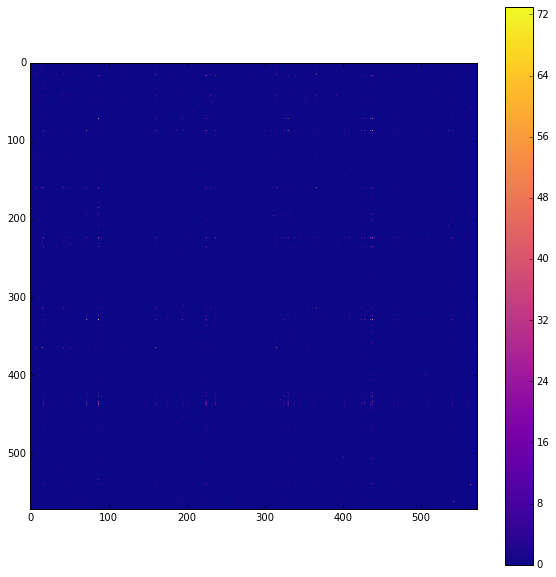

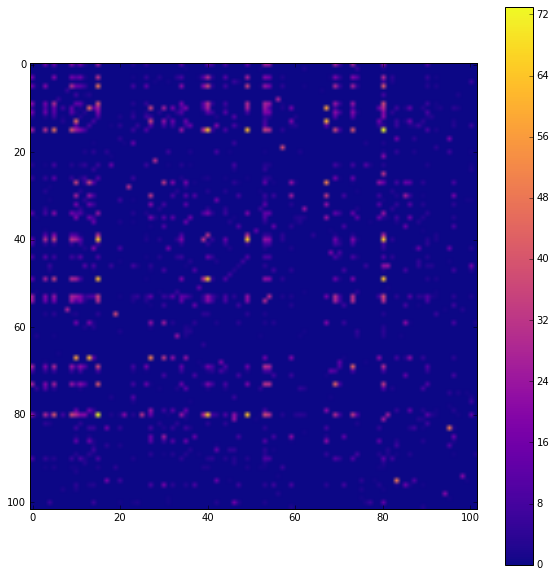

In [12]:
def build_similarity_matrix(all_reactions, min_reactions=5):
    user_reactions = dict()

    # attach reactions to its user
    for reaction in all_reactions:
        id = reaction['userid']
        if id not in user_reactions:
            user_reactions[id] = set([reaction['comment_id']])
        else:
            user_reactions[id].add(reaction['comment_id'])
            
    cleaned_users = dict()
    for user_id in user_reactions:
        if len(user_reactions[user_id]) >= min_reactions:
            cleaned_users[user_id] = user_reactions[user_id]
    
    user_reactions = cleaned_users
    
    # compare reaction sets of every two users
    user_matrix = np.zeros((len(user_reactions), len(user_reactions)))
    for fidx, first_reactions in enumerate(user_reactions.values()):
        for sidx, second_reactions in enumerate(user_reactions.values()):
            overlap = first_reactions.intersection(second_reactions)
            user_matrix[fidx, sidx] = len(overlap)

    # clear the main diagonal
    for i in range(len(user_matrix)):
        user_matrix[i, i] = 0
    
    return user_matrix, user_reactions

    
# Draw the similarity matrix for all users
sm0, _ = build_similarity_matrix(all_reactions, min_reactions=0)
fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(sm0, cmap="plasma")
plt.colorbar(res)
    
# Draw the similarity matrix for users with at least X reactions
sm20, _ = build_similarity_matrix(all_reactions, min_reactions=20)
fig, ax = plt.subplots(figsize=(10, 10))
res = ax.imshow(sm20, cmap="plasma")
plt.colorbar(res)

In [13]:
def remove_zero_lines(matrix):
    matrix = matrix[:,~np.all(matrix==0, axis=0)]
    matrix = matrix[~np.all(matrix==0, axis=1)]
    return matrix

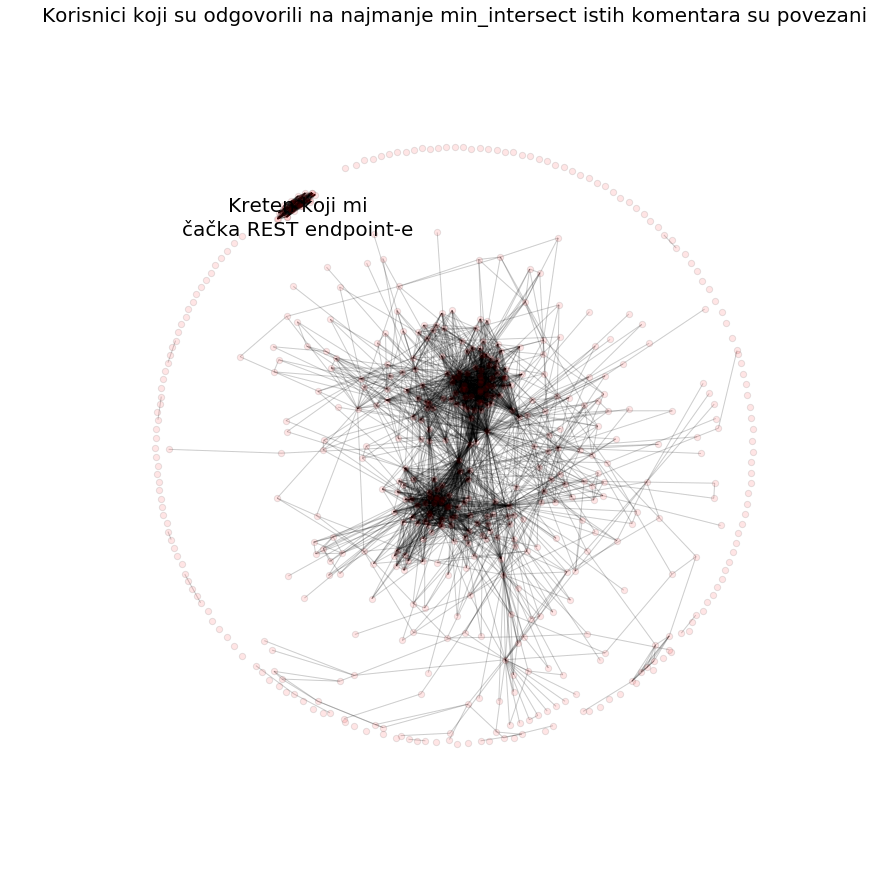

In [48]:
min_reactions = 1
min_intersect = 1

sm, users_dict = build_similarity_matrix(all_reactions, min_reactions=min_reactions)
edge_matrix = (sm >= min_intersect) * 1
G = nx.DiGraph(edge_matrix)

labels = {}
for idx, user in enumerate(users_dict):
    if user == "11111111":
        labels[idx] = u"\n\nKreten koji mi\nčačka REST endpoint-e"


fig, ax = plt.subplots(figsize=(15, 15))
draw(G, show="ipynb", ax=ax,
    weight=sm,
    iterations=200,
    arrows=False,
    node_size=40,
#     line_widths=1,
    labels=labels,
    font_size=20,
    alpha=0.1)

_ = plt.title("Korisnici koji su odgovorili na najmanje min_intersect istih komentara su povezani")

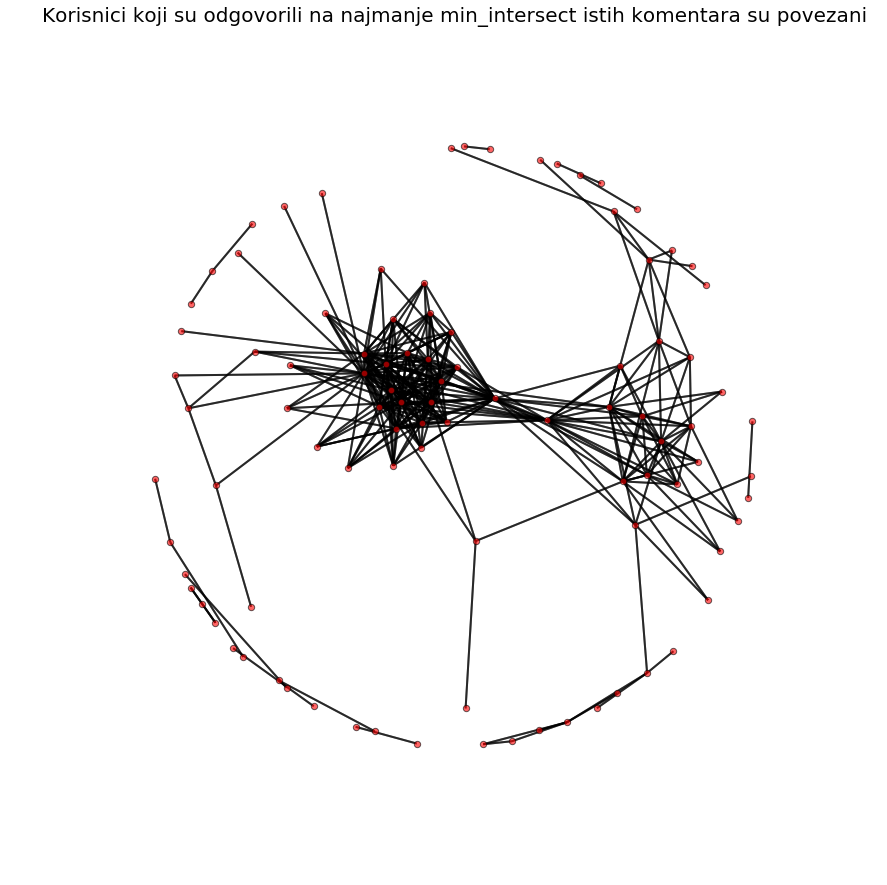

In [50]:
min_reactions = 1
min_intersect = 10

sm, users_dict = build_similarity_matrix(all_reactions, min_reactions=min_reactions)
edge_matrix = (sm >= min_intersect) * 1
edge_matrix = remove_zero_lines(edge_matrix)
G = nx.DiGraph(edge_matrix)

fig, ax = plt.subplots(figsize=(15, 15))
draw(G, show="ipynb", ax=ax,
    width=2,
    iterations=200,
    arrows=False,
    node_size=40,
    alpha=0.6)

_ = plt.title("Korisnici koji su odgovorili na najmanje min_intersect istih komentara su povezani")